Original: https://github.com/BilHim/minecraft-world-generation/blob/main/src/Minecraft%20Terrain%20Generation%20in%20Python%20-%20By%20Bilal%20Himite.ipynb
# Imports and parameters

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi
from skimage.draw import polygon
from PIL import Image
from noise import snoise3

In [2]:
size = 1024
n = 256
map_seed = 762345

In [3]:
np.random.seed(map_seed)

# Voronoi diagram

In [4]:
edge_points = size * np.array([[-1, -1], [-1, 2], [2, -1], [2, 2]])

def voronoi(points, size):
    new_points = np.vstack([points, edge_points])
    vor = Voronoi(new_points)
    return vor

def voronoi_map(vor, size):
    vor_map = np.zeros((size, size), dtype=np.uint32)
    for i, region in enumerate(vor.regions):
        if not region or -1 in region:
            continue
        vertices = vor.vertices[region]
        x, y = vertices[:, 1], vertices[:, 0]
        rr, cc = polygon(x, y)
        in_box = (0 <= rr) & (rr < size) & (0 <= cc) & (cc < size)
        vor_map[rr[in_box], cc[in_box]] = i
    return vor_map


In [5]:
points = np.random.randint(0, size, (514, 2))
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

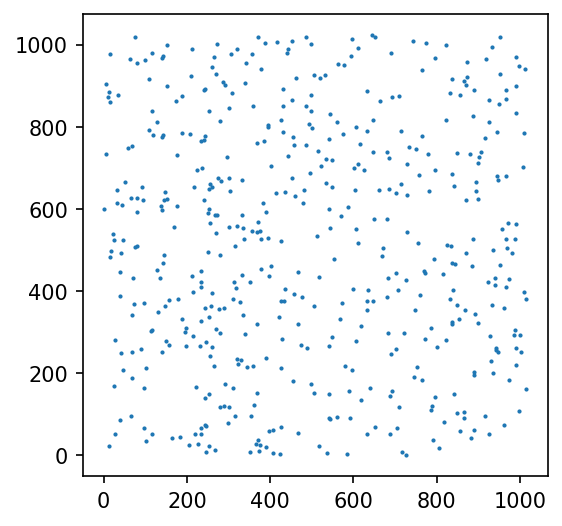

In [6]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.scatter(*points.T, s=1)

# Lloyd's relaxation

In [ ]:
def relax(points, k=10):
    for _ in range(k):
        vor = voronoi(points, size)
        new_points = [
            vor.vertices[region].mean(axis=0)
            for region in vor.regions
            if region and -1 not in region
        ]
        points = np.clip(new_points, 0, size)
    return np.array(points)


In [8]:
points = relax(points, k=100)
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

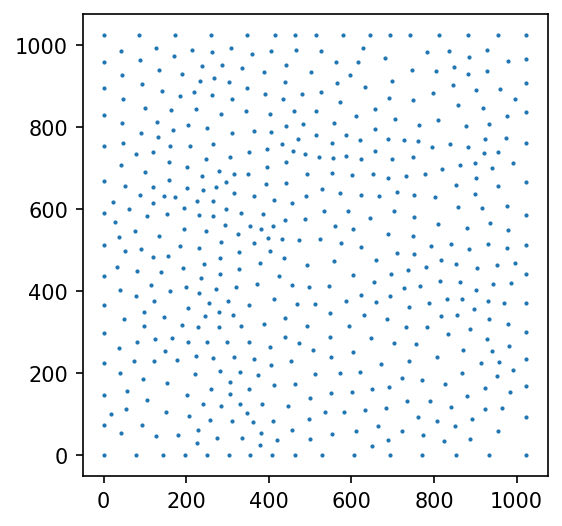

In [9]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.scatter(*points.T, s=1)

# Perlin noise / Simplex noise

In [10]:
def noise_map(size, res, seed, octaves=1, persistence=0.5, lacunarity=2.0):
    scale = size/res
    return np.array([[
        snoise3(
            (x+0.1)/scale,
            y/scale,
            seed+map_seed,
            octaves=octaves,
            persistence=persistence,
            lacunarity=lacunarity
        )
        for x in range(size)]
        for y in range(size)
    ])

# Bluring the boundaries

In [11]:
boundary_displacement = 8
boundary_noise = np.dstack([noise_map(size, 32, 200, octaves=8), noise_map(size, 32, 250, octaves=8)])
boundary_noise = np.indices((size, size)).T + boundary_displacement * boundary_noise
boundary_noise = boundary_noise.clip(0, size - 1).astype(np.uint32)

# Use advanced indexing to avoid the nested loops
blurred_vor_map = vor_map[boundary_noise[..., 1], boundary_noise[..., 0]]

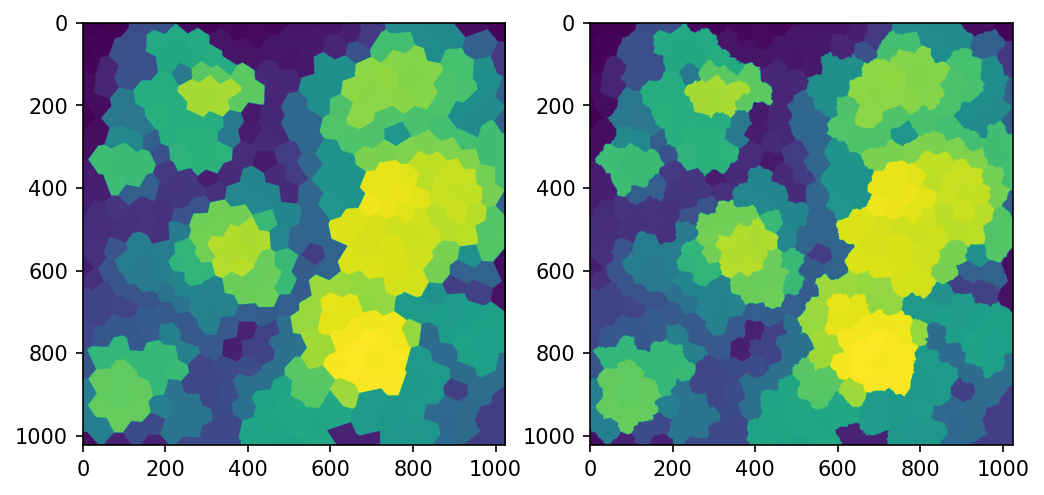

In [12]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)
axes[0].imshow(vor_map)
axes[1].imshow(blurred_vor_map)

In [13]:
vor_map = blurred_vor_map

# Choosing Biomes

## Temperature–Precipitation maps

In [14]:
temperature_map = noise_map(size, 2, 10)
precipitation_map = noise_map(size, 2, 20)

Text(0.5, 1.0, 'Precipitation Map')

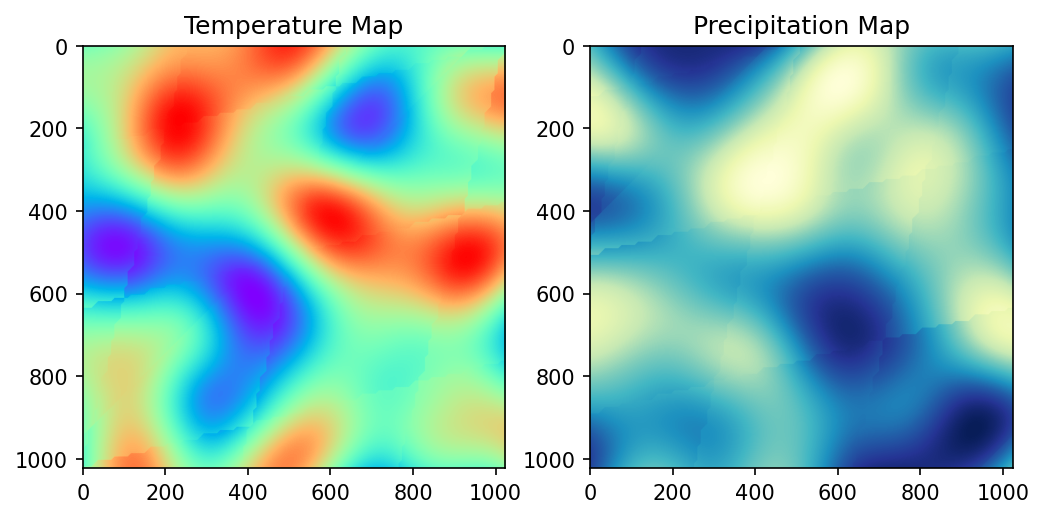

In [15]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].imshow(temperature_map, cmap="rainbow")
axes[0].set_title("Temperature Map")

axes[1].imshow(precipitation_map, cmap="YlGnBu")
axes[1].set_title("Precipitation Map")

## Histogram Equalization

[Text(0, 0, '1'),
 Text(0, 128, '0.5'),
 Text(0, 256, '0'),
 Text(0, 385, '-0.5'),
 Text(0, 511, '-1')]

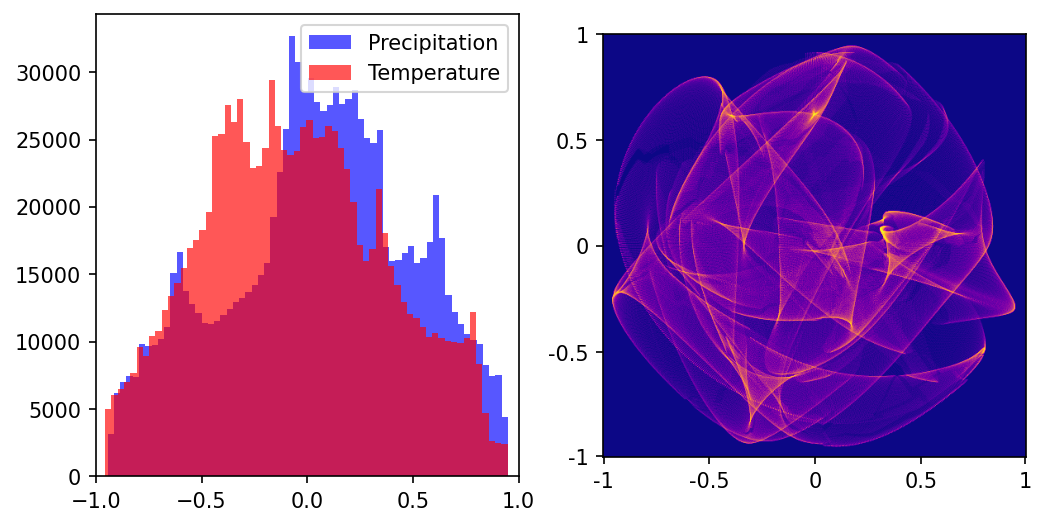

In [16]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].hist(temperature_map.flatten(), bins=64, color="blue", alpha=0.66, label="Precipitation")
axes[0].hist(precipitation_map.flatten(), bins=64, color="red", alpha=0.66, label="Temperature")
axes[0].set_xlim(-1, 1)
axes[0].legend()

hist2d = np.histogram2d(
    temperature_map.flatten(), precipitation_map.flatten(),
    bins=(512, 512), range=((-1, 1), (-1, 1))
)[0]

from scipy.special import expit
hist2d = np.interp(hist2d, (hist2d.min(), hist2d.max()), (0, 1))
hist2d = expit(hist2d/0.1)

axes[1].imshow(hist2d, cmap="plasma")

axes[1].set_xticks([0, 128, 256, 385, 511])
axes[1].set_xticklabels([-1, -0.5, 0, 0.5, 1])
axes[1].set_yticks([0, 128, 256, 385, 511])
axes[1].set_yticklabels([1, 0.5, 0, -0.5, -1])

In [17]:
from skimage import exposure

def histeq(img,  alpha=1):
    img_cdf, bin_centers = exposure.cumulative_distribution(img)
    img_eq = np.interp(img, bin_centers, img_cdf)
    img_eq = np.interp(img_eq, (0, 1), (-1, 1))
    return alpha * img_eq + (1 - alpha) * img

In [18]:
uniform_temperature_map = histeq(temperature_map, alpha=0.33)
uniform_precipitation_map = histeq(precipitation_map, alpha=0.33)

[Text(0, 0, '1'),
 Text(0, 128, '0.5'),
 Text(0, 256, '0'),
 Text(0, 385, '-0.5'),
 Text(0, 511, '-1')]

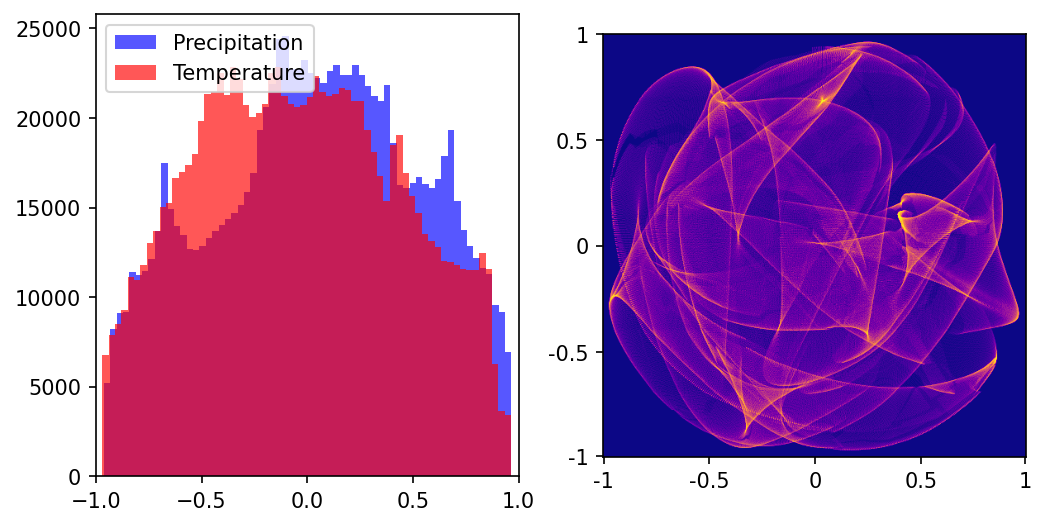

In [19]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].hist(uniform_temperature_map.flatten(), bins=64, color="blue", alpha=0.66, label="Precipitation")
axes[0].hist(uniform_precipitation_map.flatten(), bins=64, color="red", alpha=0.66, label="Temperature")
axes[0].set_xlim(-1, 1)
axes[0].legend()

hist2d = np.histogram2d(
    uniform_temperature_map.flatten(), uniform_precipitation_map.flatten(),
    bins=(512, 512), range=((-1, 1), (-1, 1))
)[0]

from scipy.special import expit
hist2d = np.interp(hist2d, (hist2d.min(), hist2d.max()), (0, 1))
hist2d = expit(hist2d/0.1)

axes[1].imshow(hist2d, cmap="plasma")

axes[1].set_xticks([0, 128, 256, 385, 511])
axes[1].set_xticklabels([-1, -0.5, 0, 0.5, 1])
axes[1].set_yticks([0, 128, 256, 385, 511])
axes[1].set_yticklabels([1, 0.5, 0, -0.5, -1])

In [20]:
temperature_map = uniform_temperature_map
precipitation_map = uniform_precipitation_map

## Averaging Cells

In [21]:
def average_cells(vor, data):
    """Returns the average value of data inside every voronoi cell"""
    size = vor.shape[0]
    count = np.max(vor)+1

    sum_ = np.zeros(count)
    count = np.zeros(count)

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            count[p] += 1
            sum_[p] += data[i, j]

    average = sum_/count
    average[count==0] = 0

    return average

def fill_cells(vor, data):
    size = vor.shape[0]
    image = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            image[i, j] = data[p]

    return image

def color_cells(vor, data, dtype=int):
    size = vor.shape[0]
    image = np.zeros((size, size, 3))

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            image[i, j] = data[p]

    return image.astype(dtype)

In [22]:
temperature_cells = average_cells(vor_map, temperature_map)
precipitation_cells = average_cells(vor_map, precipitation_map)

temperature_map = fill_cells(vor_map, temperature_cells)
precipitation_map = fill_cells(vor_map, precipitation_cells)

/tmp/ipykernel_41376/1938402209.py:15: RuntimeWarning: invalid value encountered in divide
  average = sum_/count


Text(0.5, 1.0, 'Precipitation')

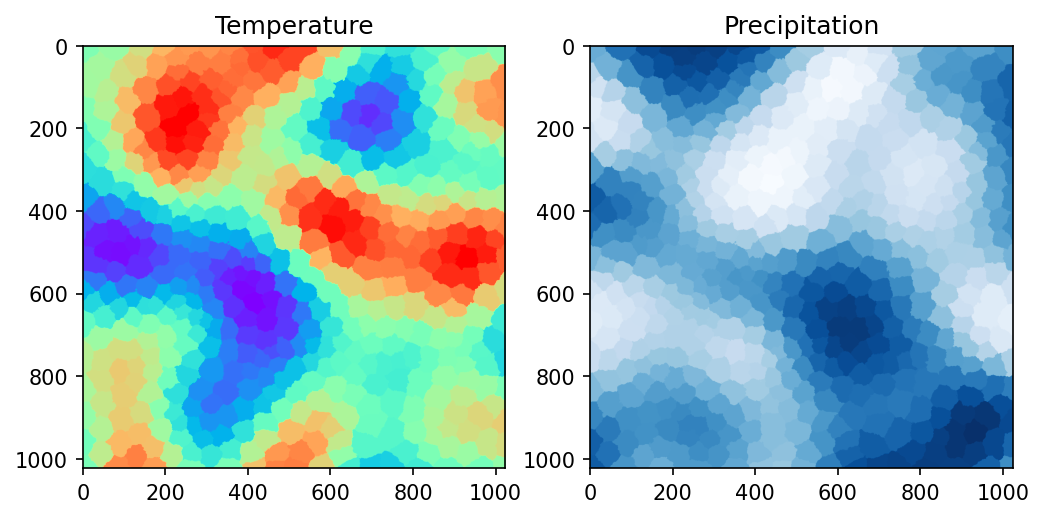

In [23]:
fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

ax[0].imshow(temperature_map, cmap="rainbow")
ax[0].set_title("Temperature")

ax[1].imshow(precipitation_map, cmap="Blues")
ax[1].set_title("Precipitation")

## Quantization

In [24]:
def quantize(data, n):
    bins = np.linspace(-1, 1, n+1)
    return (np.digitize(data, bins) - 1).clip(0, n-1)

n = 256

quantize_temperature_cells = quantize(temperature_cells, n)
quantize_precipitation_cells = quantize(precipitation_cells, n)

quantize_temperature_map = fill_cells(vor_map, quantize_temperature_cells)
quantize_precipitation_map = fill_cells(vor_map, quantize_precipitation_cells)

In [25]:
temperature_cells = quantize_temperature_cells
precipitation_cells = quantize_precipitation_cells

temperature_map = quantize_temperature_map
precipitation_map = quantize_precipitation_map

## Temperature–Precipitation graph

In [26]:
im = np.array(Image.open("TP_map.png"))[:, :, :3]
biomes = np.zeros((256, 256))

biome_names = [
  "desert",
  "savanna",
  "tropical_woodland",
  "tundra",
  "seasonal_forest",
  "rainforest",
  "temperate_forest",
  "temperate_rainforest",
  "boreal_forest"
]
biome_colors = [
  [255, 255, 178],
  [184, 200, 98],
  [188, 161, 53],
  [190, 255, 242],
  [106, 144, 38],
  [33, 77, 41],
  [86, 179, 106],
  [34, 61, 53],
  [35, 114, 94]
]

for i, color in enumerate(biome_colors):
    indices = np.where(np.all(im == color, axis=-1))
    biomes[indices] = i
    
biomes = np.flip(biomes, axis=0).T

Text(0.5, 1.0, 'Temperature–Precipitation graph')

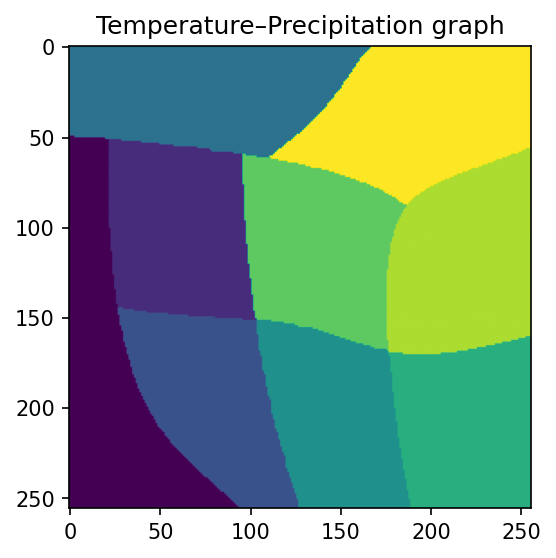

In [27]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.imshow(biomes)
plt.title("Temperature–Precipitation graph")

## Biome map

In [28]:
n = len(temperature_cells)
biome_cells = np.zeros(n, dtype=np.uint32)

for i in range(n):
    temp, precip = temperature_cells[i], precipitation_cells[i]
    biome_cells[i] = biomes[temp, precip]
    
biome_map = fill_cells(vor_map, biome_cells).astype(np.uint32)
biome_color_map = color_cells(biome_map, biome_colors)

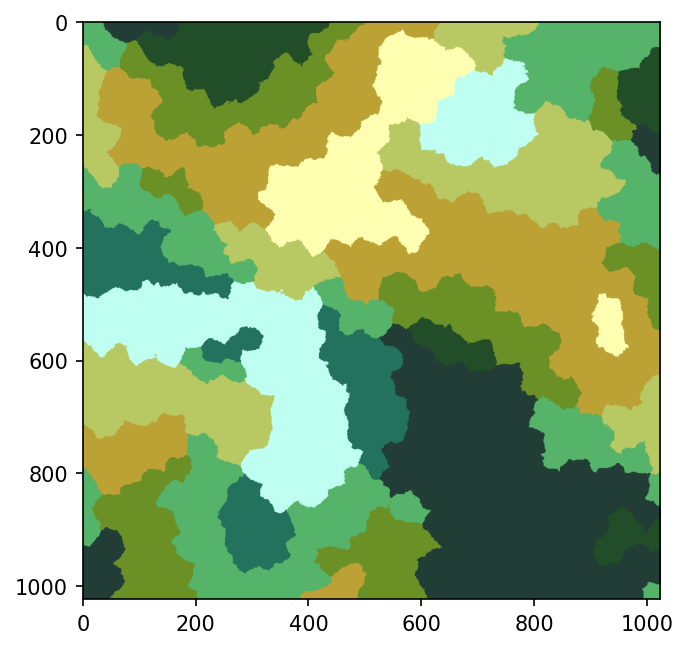

In [29]:
fig = plt.figure(figsize=(5, 5), dpi=150)
plt.imshow(biome_color_map)

# Height Map

In [30]:
height_map = noise_map(size, 4, 0, octaves=6, persistence=0.5, lacunarity=2)
land_mask = height_map > 0

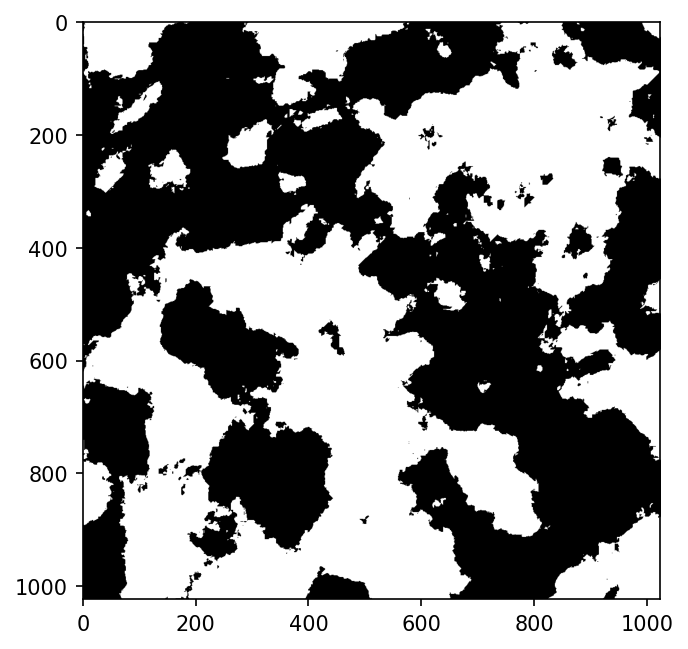

In [31]:
fig = plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(land_mask, cmap='gray')

In [32]:
sea_color = np.array([12, 14, 255])
land_mask_color = np.repeat(land_mask[:, :, np.newaxis], 3, axis=-1)
masked_biome_color_map = land_mask_color*biome_color_map + (1-land_mask_color)*sea_color

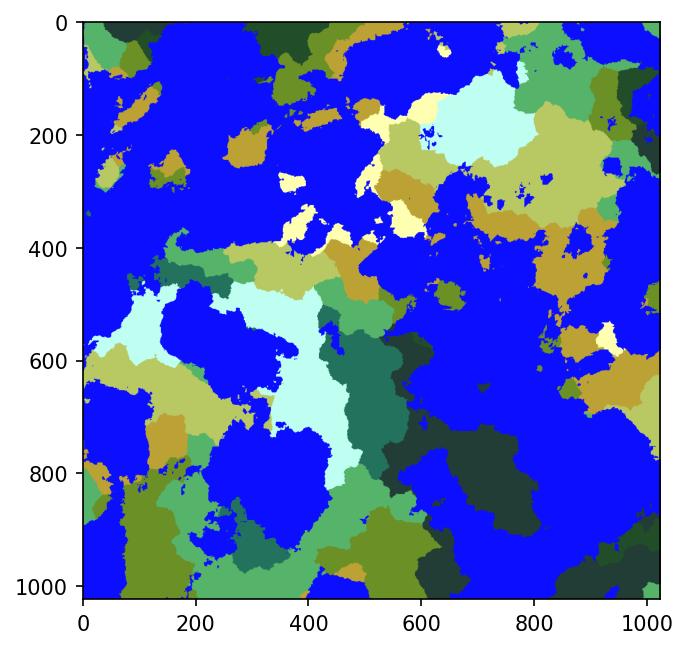

In [33]:
fig = plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(masked_biome_color_map)

In [34]:
# https://github.com/Mehdi-Antoine/NormalMapGenerator

from scipy import ndimage

def gradient(im_smooth):
    gradient_x = im_smooth.astype(float)
    gradient_y = im_smooth.astype(float)

    kernel = np.arange(-1,2).astype(float)
    kernel = - kernel / 2

    gradient_x = ndimage.convolve(gradient_x, kernel[np.newaxis])
    gradient_y = ndimage.convolve(gradient_y, kernel[np.newaxis].T)

    return gradient_x, gradient_y

def sobel(im_smooth):
    gradient_x = im_smooth.astype(float)
    gradient_y = im_smooth.astype(float)

    kernel = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

    gradient_x = ndimage.convolve(gradient_x, kernel)
    gradient_y = ndimage.convolve(gradient_y, kernel.T)

    return gradient_x, gradient_y

def compute_normal_map(gradient_x, gradient_y, intensity=1):
    width = gradient_x.shape[1]
    height = gradient_x.shape[0]
    max_x = np.max(gradient_x)
    max_y = np.max(gradient_y)

    max_value = max_x

    if max_y > max_x:
        max_value = max_y

    normal_map = np.zeros((height, width, 3), dtype=np.float32)

    intensity = 1 / intensity

    strength = max_value / (max_value * intensity)

    normal_map[..., 0] = gradient_x / max_value
    normal_map[..., 1] = gradient_y / max_value
    normal_map[..., 2] = 1 / strength

    norm = np.sqrt(np.power(normal_map[..., 0], 2) + np.power(normal_map[..., 1], 2) + np.power(normal_map[..., 2], 2))

    normal_map[..., 0] /= norm
    normal_map[..., 1] /= norm
    normal_map[..., 2] /= norm

    normal_map *= 0.5
    normal_map += 0.5

    return normal_map


def get_normal_map(im, intensity=1.0):
    sobel_x, sobel_y = sobel(im)
    normal_map = compute_normal_map(sobel_x, sobel_y, intensity)
    return normal_map

def get_normal_light(height_map_):
    normal_map_ = get_normal_map(height_map_)[:,:,0:2].mean(axis=2)
    normal_map_ = np.interp(normal_map_, (0, 1), (-1, 1))
    return normal_map_

def apply_height_map(im_map, smooth_map, height_map, land_mask):
    normal_map = get_normal_light(height_map)
    normal_map =  normal_map*land_mask + smooth_map/2*(~land_mask)

    normal_map = np.interp(normal_map, (-1, 1), (-192, 192))

    normal_map_color = np.repeat(normal_map[:, :, np.newaxis], 3, axis=-1)
    normal_map_color = normal_map_color.astype(int)

    out_map = im_map + normal_map_color
    return out_map, normal_map

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-60..347].


Text(0.5, 1.0, 'Biomes with normal')

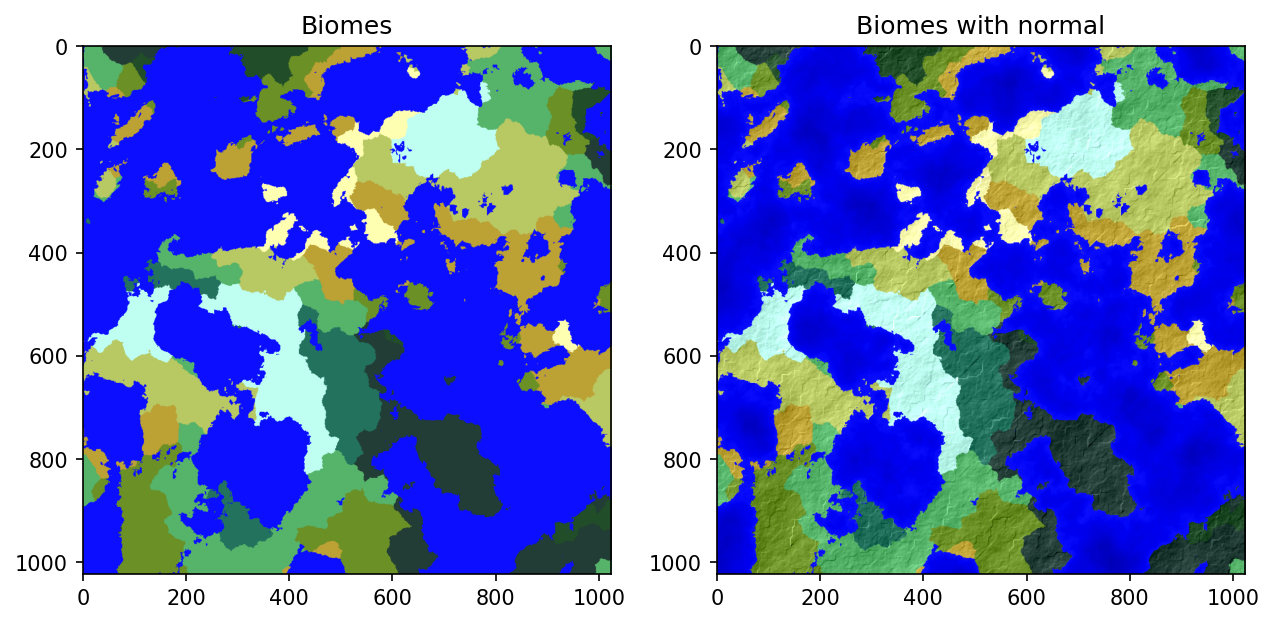

In [35]:
biome_height_map, normal_map = apply_height_map(masked_biome_color_map, height_map, height_map, land_mask)

fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(10, 5)

ax[0].imshow(masked_biome_color_map)
ax[0].set_title("Biomes")

ax[1].imshow(biome_height_map)
ax[1].set_title("Biomes with normal")

## Height Map Detail

In [36]:
height_map = noise_map(size, 4, 0, octaves=6, persistence=0.5, lacunarity=2)
smooth_height_map = noise_map(size, 4, 0, octaves=1, persistence=0.5, lacunarity=2)

Text(0.5, 1.0, 'Smooth Height Map')

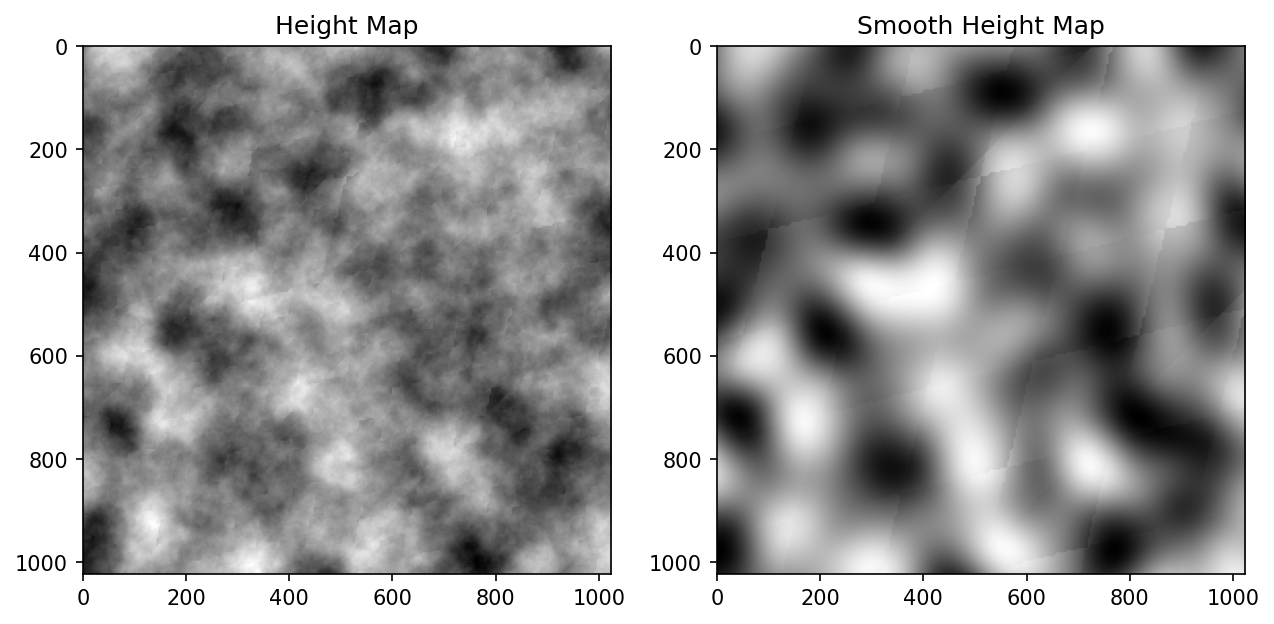

In [37]:
fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(10, 5)

ax[0].imshow(height_map, cmap="gray")
ax[0].set_title("Height Map")

ax[1].imshow(smooth_height_map, cmap="gray")
ax[1].set_title("Smooth Height Map")

## Height Map Filters

### Bézier Curves

In [38]:
def bezier(x1, y1, x2, y2, a):
    p1 = np.array([0, 0])
    p2 = np.array([x1, y1])
    p3 = np.array([x2, y2])
    p4 = np.array([1, a])

    return lambda t: ((1-t)**3 * p1 + 3*(1-t)**2*t * p2 + 3*(1-t)*t**2 * p3 + t**3 * p4)

In [39]:
from scipy.interpolate import interp1d

def bezier_lut(x1, y1, x2, y2, a):
    t = np.linspace(0, 1, 256)
    f = bezier(x1, y1, x2, y2, a)
    curve = np.array([f(t_) for t_ in t])

    return interp1d(*curve.T)

def filter_map(h_map, smooth_h_map, x1, y1, x2, y2, a, b):
    f = bezier_lut(x1, y1, x2, y2, a)
    output_map = b*h_map + (1-b)*smooth_h_map
    output_map = f(output_map.clip(0, 1))
    return output_map

In [40]:
# f = bezier_lut(0.8, 0.1, 0.9, 0.05, 0.05)
# t = np.linspace(0, 1, 1000)
# y = f(t)

# from matplotlib.gridspec import GridSpec

# fig = plt.figure(dpi=120, figsize=(8, 8/3))
# gs = GridSpec(1, 3)

# ax1 = plt.subplot(gs[:,:1])
# ax1.plot(t, y)
# ax1.set_xlim(0, 1)
# ax1.set_ylim(0, 1)
# ax1.set_title("Boreal Filter")

# ax2 = plt.subplot(gs[:,1:])
# ax2.plot(height_map[100].clip(0, 1))
# ax2.plot(boreal_map[100])
# ax2.set_ylim(0, 1)
# ax2.set_title("Example")

# plt.savefig("figures/figure_13/9.jpg")

### Filters

In [41]:
biome_height_maps = [
    # Desert
    filter_map(height_map, smooth_height_map, 0.75, 0.2, 0.95, 0.2, 0.2, 0.5),
    # Savanna
    filter_map(height_map, smooth_height_map, 0.5, 0.1, 0.95, 0.1, 0.1, 0.2),
    # Tropical Woodland
    filter_map(height_map, smooth_height_map, 0.33, 0.33, 0.95, 0.1, 0.1, 0.75),
    # Tundra
    filter_map(height_map, smooth_height_map, 0.5, 1, 0.25, 1, 1, 1),
    # Seasonal Forest
    filter_map(height_map, smooth_height_map, 0.75, 0.5, 0.4, 0.4, 0.33, 0.2),
    # Rainforest
    filter_map(height_map, smooth_height_map, 0.5, 0.25, 0.66, 1, 1, 0.5),
    # Temperate forest
    filter_map(height_map, smooth_height_map, 0.75, 0.5, 0.4, 0.4, 0.33, 0.33),
    # Temperate Rainforest
    filter_map(height_map, smooth_height_map, 0.75, 0.5, 0.4, 0.4, 0.33, 0.33),
    # Boreal
    filter_map(height_map, smooth_height_map, 0.8, 0.1, 0.9, 0.05, 0.05, 0.1)
]

### Biome masks

In [42]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.morphology import binary_dilation

biome_count = len(biome_names)
biome_masks = np.zeros((biome_count, size, size))

for i in range(biome_count):
    biome_masks[i, biome_map==i] = 1
    biome_masks[i] = gaussian_filter(biome_masks[i], sigma=16)

# Remove ocean from masks
blurred_land_mask = land_mask
blurred_land_mask = binary_dilation(land_mask, iterations=32).astype(np.float64)
blurred_land_mask = gaussian_filter(blurred_land_mask, sigma=16)

biome_masks = biome_masks*blurred_land_mask

/tmp/ipykernel_41376/1678731906.py:1: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipykernel_41376/1678731906.py:2: DeprecationWarning: Please import `binary_dilation` from the `scipy.ndimage` namespace; the `scipy.ndimage.morphology` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.morphology import binary_dilation


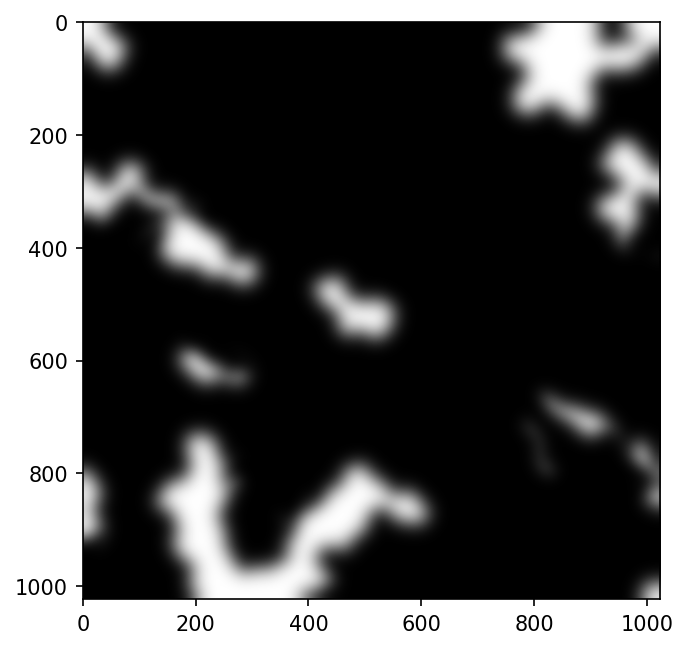

In [43]:
plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(biome_masks[6], cmap="gray")

### Applying Filters

In [44]:
adjusted_height_map = height_map.copy()

for i in range(len(biome_height_maps)):
    adjusted_height_map = (1-biome_masks[i])*adjusted_height_map + biome_masks[i]*biome_height_maps[i]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-60..355].


Text(0.5, 1.0, 'After')

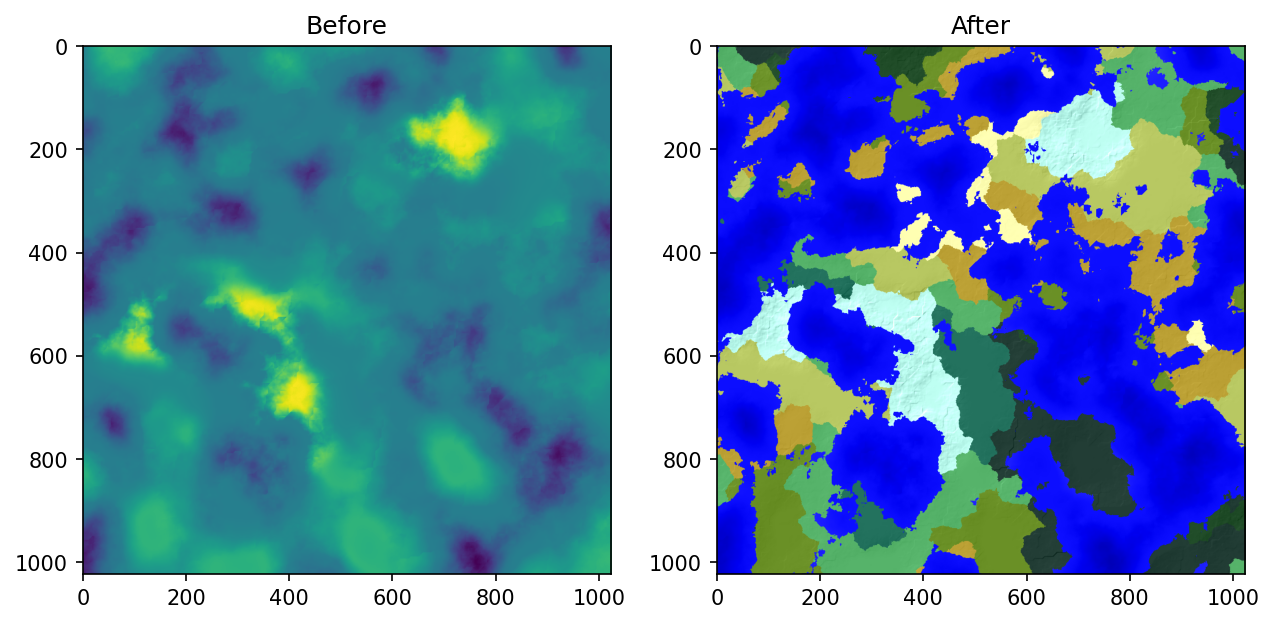

In [45]:
biome_height_map = apply_height_map(masked_biome_color_map, height_map, height_map, land_mask)
new_biome_height_map = apply_height_map(masked_biome_color_map, adjusted_height_map, adjusted_height_map, land_mask)

fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(10, 5)

ax[0].imshow(adjusted_height_map)
ax[0].set_title("Before")

ax[1].imshow(new_biome_height_map[0])
ax[1].set_title("After")

# Rivers

## Boundaries

In [46]:
def get_boundary(vor_map, kernel=1):
    n, m = vor_map.shape
    boundary_map = np.zeros((n, m), dtype=bool)
    
    for i in range(-kernel, kernel + 1):
        for j in range(-kernel, kernel + 1):
            if i == 0 and j == 0:
                continue
            shifted_map = np.roll(vor_map, shift=(i, j), axis=(0, 1))
            boundary_map |= (vor_map != shifted_map)
    
    return boundary_map

In [47]:
biome_bound = get_boundary(biome_map, kernel=5)
cell_bound = get_boundary(vor_map, kernel=2)

In [48]:
river_mask = noise_map(size, 4, 4353, octaves=6, persistence=0.5, lacunarity=2) > 0

new_biome_bound = biome_bound*(adjusted_height_map<0.5)*land_mask
new_cell_bound = cell_bound*(adjusted_height_map<0.05)*land_mask

rivers = np.logical_or(new_biome_bound, new_cell_bound)*river_mask

In [49]:
loose_river_mask = binary_dilation(rivers, iterations=8)
rivers_height = gaussian_filter(rivers.astype(np.float64), sigma=2)*loose_river_mask

In [50]:
adjusted_height_river_map = adjusted_height_map*(1-rivers_height) - 0.05*rivers

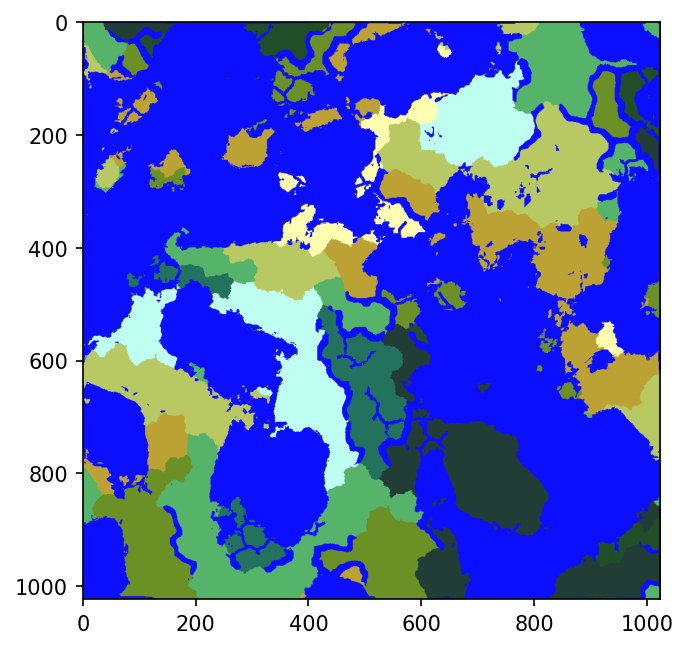

In [51]:
river_land_mask = adjusted_height_river_map >= 0
land_mask_color = np.repeat(river_land_mask[:, :, np.newaxis], 3, axis=-1)
rivers_biome_color_map = land_mask_color*biome_color_map + (1-land_mask_color)*sea_color

plt.figure(dpi=150, figsize=(5, 5))
plt.imshow(rivers_biome_color_map)

In [52]:
# color_map = apply_height_map(rivers_biome_color_map, adjusted_height_river_map, adjusted_height_river_map, river_land_mask)
# plt.imshow(color_map[0])

# im = Image.fromarray(color_map[0].clip(0, 255).astype(np.uint8))
# im.save("figures/10.png")

# Trees and Vegetation

In [53]:
def filter_inbox(pts):
    return pts[np.all(pts < size, axis=1)]

def generate_trees(n):
    trees = np.random.randint(0, size-1, (n, 2))
    trees = relax(trees, k=10).astype(np.uint32)
    trees = filter_inbox(trees)
    return trees


In [ ]:
from multiprocessing import Pool
# Example
with Pool() as pool:
    densities = pool.starmap(generate_trees, [(n,) for n in [
        1000, 5000, 25000
    ]])

(0.0, 256.0)

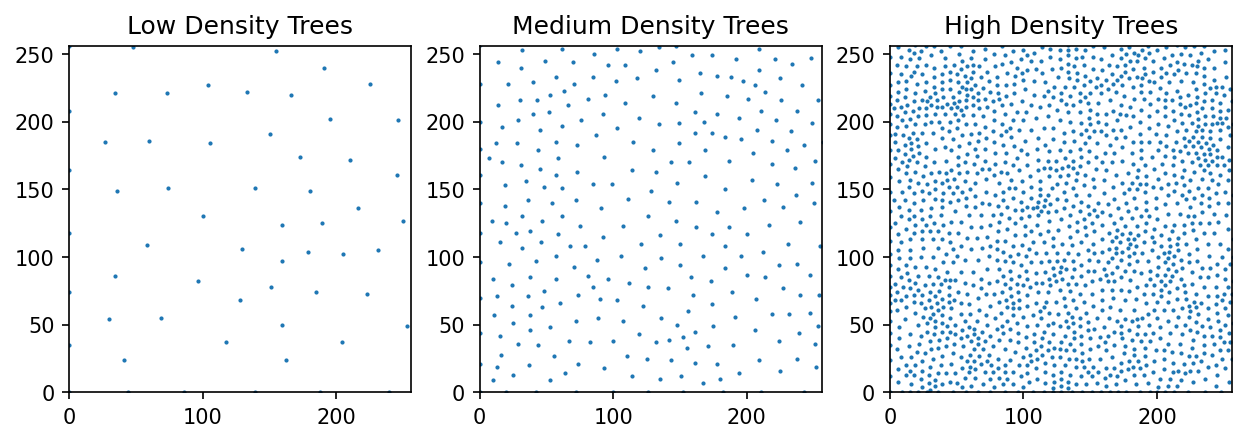

In [55]:
plt.figure(dpi=150, figsize=(10, 3))
plt.subplot(131)
plt.scatter(*densities[0].T, s=1)
plt.title("Low Density Trees")
plt.xlim(0, 256)
plt.ylim(0, 256)

plt.subplot(132)
plt.scatter(*densities[1].T, s=1)
plt.title("Medium Density Trees")
plt.xlim(0, 256)
plt.ylim(0, 256)

plt.subplot(133)
plt.scatter(*densities[2].T, s=1)
plt.title("High Density Trees")
plt.xlim(0, 256)
plt.ylim(0, 256)

In [56]:
def place_trees(n, mask, a=0.5):
    """
    Place trees within a specific mask based on conditions.

    Parameters:
    - n (int): Number of trees to generate.
    - mask (ndarray): A 2D array representing the allowed placement areas.
    - a (float): Threshold value for the mask.

    Returns:
    - ndarray: Array of valid tree positions as (x, y) coordinates.
    """
    # Generate random tree positions
    trees = generate_trees(n)
    rr, cc = trees.T

    # Create a boolean mask for the trees
    valid_positions = (
        (mask[rr, cc] > a) &
        (river_land_mask[rr, cc]) &
        (adjusted_height_river_map[rr, cc] < 0.5)
    )

    # Apply the mask to filter valid tree positions
    rr, cc = rr[valid_positions], cc[valid_positions]

    # Return the positions as an array of (x, y) coordinates
    return np.column_stack((cc, rr))


In [57]:
tree_densities = [4000, 1500, 8000, 1000, 10000, 25000, 10000, 20000, 5000]
def parallel_place_trees(tree_density, mask):
    return np.array(place_trees(tree_density, mask))

# Parallel execution
with Pool() as pool:
    trees = pool.starmap(
        parallel_place_trees, 
        [(tree_densities[i], biome_masks[i]) for i in range(len(biome_names))]
    )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-60..355].


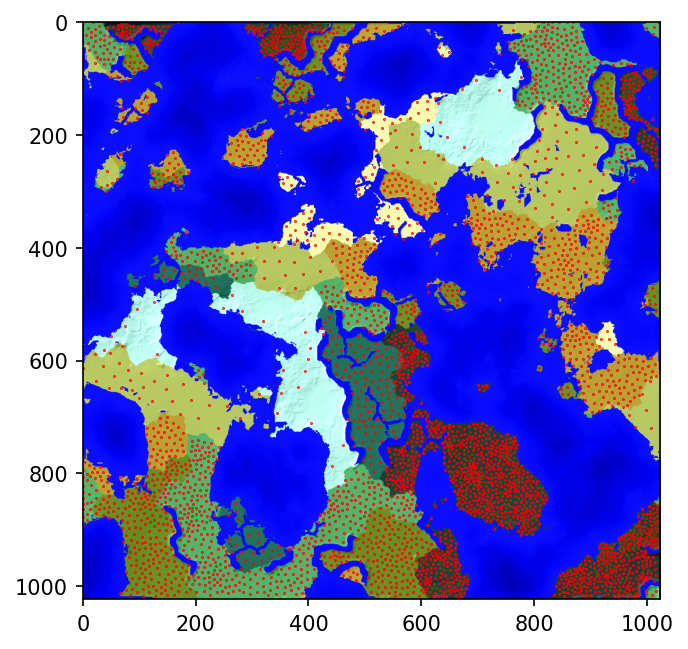

In [58]:
color_map = apply_height_map(rivers_biome_color_map, adjusted_height_river_map, adjusted_height_river_map, river_land_mask)

plt.figure(dpi=150, figsize=(5, 5))
for k in range(len(biome_names)):
    plt.scatter(*trees[k].T, s=0.15, c="red")

plt.imshow(color_map[0])